In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json


from datetime import datetime, timedelta, timezone
from pathlib import Path
from supabase import create_client
from dotenv import load_dotenv

load_dotenv()

# --- Style defaults to match my portfolio ---
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Outfit", "Arial", "Helvetica", "DejaVu Sans"]
plt.rcParams["figure.facecolor"] = "#ffffff"
plt.rcParams["axes.facecolor"] = "#ffffff"
plt.rcParams["text.color"] = "#171717"
plt.rcParams["axes.labelcolor"] = "#171717"
plt.rcParams["xtick.color"] = "#171717"
plt.rcParams["ytick.color"] = "#171717"



SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SERVICE_ROLE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

def fetch_readings_from_supabase(days: int = 30, page_size: int = 1000, max_rows: int | None = None):
    client = create_client(SUPABASE_URL, SUPABASE_SERVICE_ROLE_KEY)
    since = (datetime.now(timezone.utc) - timedelta(days=days))\
        .isoformat(timespec="seconds").replace("+00:00", "Z")

    rows, offset = [], 0
    while True:
        q = (
            client.table("temperature_readings")      # or .postgrest.from_(...)
                  .select("transformer_id,timestamp,tempC, ambient_temperature")
                  .gte("timestamp", since)
                  .order("timestamp", desc=False)
                  .range(offset, offset + page_size - 1)
        )
        try:
            res = q.execute()
        except Exception as e:
            raise RuntimeError(f"Supabase fetch failed: {e}") from e

        batch = res.data or []
        rows.extend(batch)

        # stop conditions
        if len(batch) < page_size:
            break
        offset += page_size
        if max_rows and len(rows) >= max_rows:
            rows = rows[:max_rows]
            break

    return rows

DATA_PATH = Path("../data/readings.csv")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True)
OVERHEAT_THRESHOLD = float(os.getenv("OVERHEAT_THRESHOLD", "100"))


In [2]:
rows = fetch_readings_from_supabase(days=30, page_size=1000, max_rows=100000)
df = pd.DataFrame(rows)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
print("Fetched rows:", len(df))
print("time span:", df["timestamp"].min(), "→", df["timestamp"].max(), f"({len(df)} rows)")
df = df.sort_values("timestamp").dropna(subset=["tempC"])
df.head()

Fetched rows: 19980
time span: 2025-07-20 04:00:00+00:00 → 2025-08-19 23:00:00+00:00 (19980 rows)


,transformer_id,timestamp,tempC
0,XFMR-0005,2025-07-20 04:00:00+00:00,93.04
26,XFMR-2184,2025-07-20 04:00:00+00:00,90.19
25,XFMR-0009,2025-07-20 04:00:00+00:00,77.88
24,XFMR-0001,2025-07-20 04:00:00+00:00,82.06
23,XFMR-0421,2025-07-20 04:00:00+00:00,81.96


In [3]:

# --- Ensure IDs are strings BEFORE any groupbys/joins ---
df["transformer_id"] = df["transformer_id"].astype(str)

# 1) Summary per transformer (avg/max/count)
summary = (
    df.groupby("transformer_id", as_index=True)
      .agg(
          avg_temp=("tempC", "mean"),
          max_temp=("tempC", "max"),
          count=("tempC", "size"),
      )
      .round(2)
)

# 2) Helper: hours above threshold in a window (linear interpolation)
def hours_over_threshold_window(g: pd.DataFrame, thresh: float,
                                start: pd.Timestamp, end: pd.Timestamp) -> float:
    s = g[["timestamp", "tempC"]].dropna().sort_values("timestamp")
    if len(s) < 2:
        return 0.0
    t0 = s["timestamp"].astype("int64").to_numpy() / 1e9
    t1 = s["timestamp"].shift(-1).astype("int64").to_numpy() / 1e9
    y0 = s["tempC"].to_numpy(dtype=float)
    y1 = s["tempC"].shift(-1).to_numpy(dtype=float)
    mask = ~np.isnan(t1)
    t0, t1, y0, y1 = t0[mask], t1[mask], y0[mask], y1[mask]
    if t0.size == 0:
        return 0.0

    start_s = start.value / 1e9
    end_s   = end.value   / 1e9
    sel = (t1 > start_s) & (t0 < end_s)
    if not np.any(sel):
        return 0.0
    t0, t1, y0, y1 = t0[sel], t1[sel], y0[sel], y1[sel]
    ts = np.maximum(t0, start_s)
    te = np.minimum(t1, end_s)

    denom = (t1 - t0)
    denom[denom == 0.0] = np.nan
    m = (y1 - y0) / denom  # °C/s

    above_ms = np.zeros_like(ts)

    both_above = (y0 > thresh) & (y1 > thresh)
    above_ms[both_above] = (te[both_above] - ts[both_above]) * 1000

    crossing = ((y0 > thresh) ^ (y1 > thresh)) & np.isfinite(m)
    if np.any(crossing):
        t_cross = t0[crossing] + (thresh - y0[crossing]) / m[crossing]
        falling = (y0[crossing] > thresh) & (y1[crossing] <= thresh)
        rising  = ~falling
        t_left  = np.maximum(ts[crossing], t_cross)
        t_right = np.minimum(te[crossing], t_cross)
        above_ms[crossing][falling] += np.maximum(0, (t_right[falling] - ts[crossing][falling]) * 1000)
        above_ms[crossing][rising]  += np.maximum(0, (te[crossing][rising] - t_left[rising]) * 1000)

    return float(above_ms.sum() / 3_600_000.0)  # ms -> hours

# 3) Windows and per-transformer hours (select only needed cols to avoid FutureWarning)
now_utc   = pd.Timestamp.now(tz="UTC")
start_24h = now_utc - pd.Timedelta(hours=24)
start_7d  = now_utc - pd.Timedelta(days=7)
start_30d = now_utc - pd.Timedelta(days=30)

over_24h = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_24h, now_utc))
      .rename("hours_over_thresh_24h")
)
over_7d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_7d,  now_utc))
      .rename("hours_over_thresh_7d")
)
over_30d = (
    df.groupby("transformer_id", group_keys=False)[["timestamp", "tempC"]]
      .apply(lambda g: hours_over_threshold_window(g, OVERHEAT_THRESHOLD, start_30d, now_utc))
      .rename("hours_over_thresh_30d")
)

# 4) Build and save risk table (JOIN with matched index types)
risk = (
    summary
    .join(over_24h).join(over_7d).join(over_30d)
    .fillna(0)
)
risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]] = \
    risk[["hours_over_thresh_24h","hours_over_thresh_7d","hours_over_thresh_30d"]].astype(float).round(2)

risk.to_csv(OUT_DIR / "hot_transformers.csv")
print("Saved:", OUT_DIR / "hot_transformers.csv")

# 5) Build compact dataset for the web (including per-window hours)
hours24_map = over_24h.to_dict()
hours7d_map = over_7d.to_dict()
hours30_map = over_30d.to_dict()

g = (
    df.loc[:, ["transformer_id", "timestamp", "tempC"]]
      .dropna(subset=["timestamp", "tempC"])
      .sort_values("timestamp")
)

payload = {}
for tid, chunk in g.groupby("transformer_id", sort=True):
    ts = chunk["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    payload[tid] = {
        "t": ts.tolist(),
        "y": chunk["tempC"].astype(float).round(2).tolist(),
        "h": {
            "24h": round(float(hours24_map.get(tid, 0.0)), 3),
            "7d":  round(float(hours7d_map.get(tid, 0.0)), 3),
            "30d": round(float(hours30_map.get(tid, 0.0)), 3),
        },
    }

out_json = OUT_DIR / "series.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(payload, f, separators=(",", ":"))
print(
    f"Wrote {out_json} with {len(payload)} transformers and "
    f"{sum(len(v['t']) for v in payload.values())} total points."
)


Saved: ..\outputs\hot_transformers.csv
Wrote ..\outputs\series.json with 27 transformers and 19980 total points.


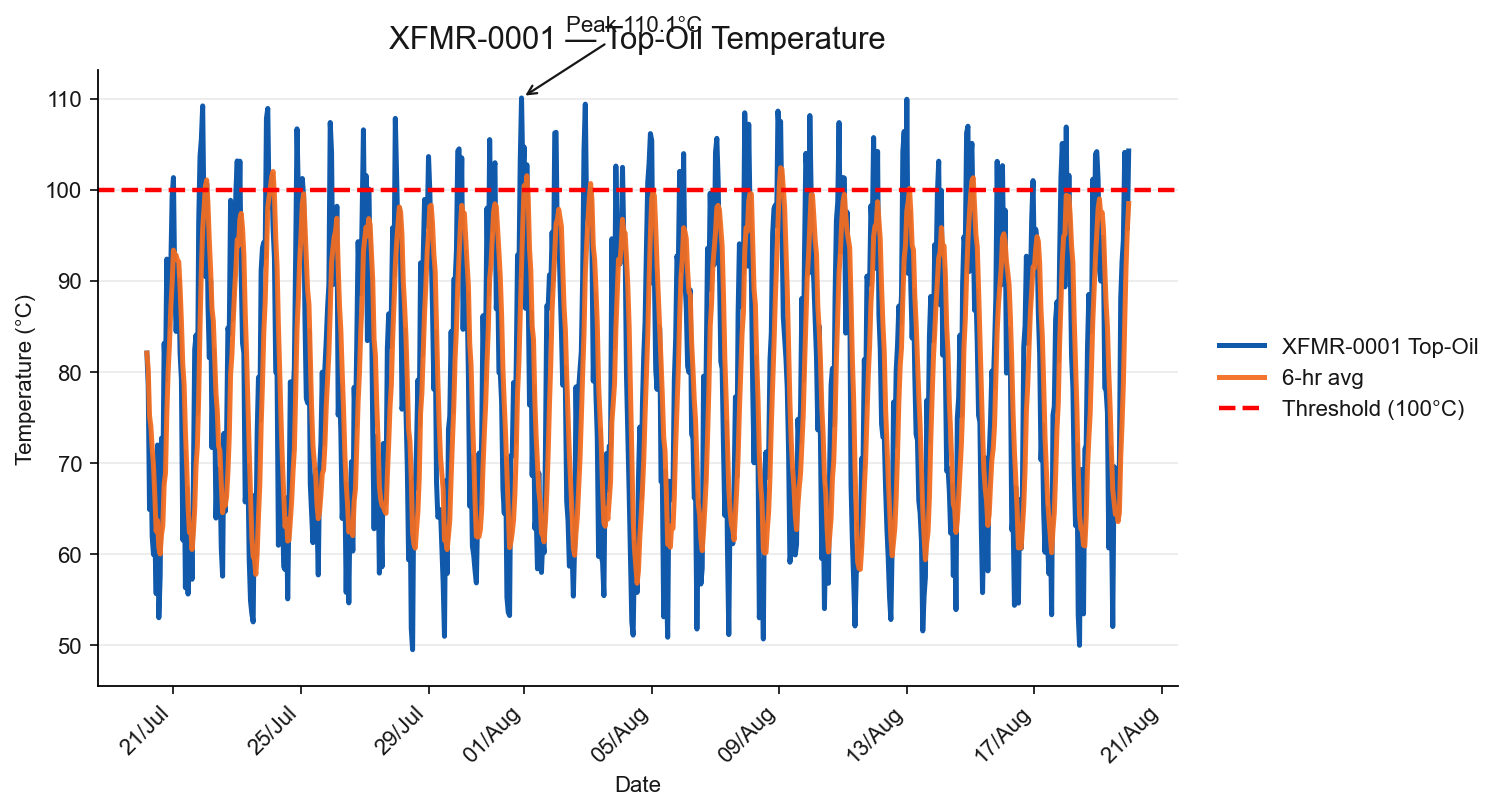

In [4]:
t_id = risk.index[0] if len(risk.index) else df["transformer_id"].iloc[0]
df_one = df[df["transformer_id"] == t_id].copy().sort_values("timestamp")
df_one["rolling_6h"] = df_one["tempC"].rolling(window=6, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(10, 5.5), dpi=160)

# Main series
ax.plot(df_one["timestamp"], df_one["tempC"], linewidth=2.25,
        label=f"{t_id} Top-Oil", color="#1059ab")

# Rolling average
ax.plot(df_one["timestamp"], df_one["rolling_6h"], linewidth=2.25,
        label="6-hr avg", color="#f26d21", alpha=0.95)

# Threshold
ax.axhline(OVERHEAT_THRESHOLD, linestyle="--", linewidth=2, color="red",
           label=f"Threshold ({OVERHEAT_THRESHOLD:.0f}°C)")

# Shade exceedances
ax.fill_between(df_one["timestamp"], df_one["tempC"], OVERHEAT_THRESHOLD,
                where=(df_one["tempC"] > OVERHEAT_THRESHOLD),
                alpha=0.12, color="red", interpolate=True)

# Peak annotation (with background box so it never gets lost)
if not df_one.empty:
    imax = df_one["tempC"].idxmax()
    ax.annotate(
        f"Peak {df_one.loc[imax,'tempC']:.1f}°C",
        xy=(df_one.loc[imax, "timestamp"], df_one.loc[imax, "tempC"]),
        xytext=(20, 30), textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=1, color="#171717"),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.85)
    )

# Labels, grid, axes cleanup
ax.set_title(f"{t_id} — Top-Oil Temperature", fontsize=14, pad=10)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)

# Date formatting and spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%b"))
plt.xticks(rotation=45, ha="right")
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 1, ymax)

# Legend OUTSIDE to the right
leg = ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# Make room for the outside legend
plt.subplots_adjust(right=0.8, bottom=0.18)

# Save PNG + SVG (crisp for portfolio)
fig.savefig(OUT_DIR / "trend_1.png", dpi=200, bbox_inches="tight")
fig.savefig(OUT_DIR / "trend_1.svg", bbox_inches="tight")
plt.show()
